# **Saturation momentum dependence of wong.py for heavy quarks**

This notebook contains momentum broadenings of heavy quarks for various values of the saturation scale $Q_s$. The `wong.py` module contains the Wong solver for dynamic partons moving through the Glasma. 

## Default simulation parameters for the Glasma and the Wong solvers

In [1]:
import numpy as np

# hbar * c [GeV * fm]
hbarc = 0.197326 

# Simulation box 
L = 10      
N = 512    
tau_sim = 8   
DTS = 8     

# Glasma
su_group = 'su3'
Qs = 2.0          
ns = 50    
factor = 0.8        
g2mu = Qs / factor     
g = np.pi * np.sqrt(1 / np.log(Qs / 0.2))          		
mu = g2mu / g**2          	
ir = 0.1 * g2mu         
uv = 10.0           

# Wong
# quark = 'charm'     
# mass = 1.27     
# # tau_form = 1/(2*mass)*hbarc   
# pT = 2 
# mT = np.sqrt(mass*2+pT**2)
# tau_form = 1/(2*mT)*hbarc 

quark = 'jet'     
mass = 0.1    
tau_form = 0.0   
# pT = 10 
px = 10
# initialization_type = 'pT'
initialization_type = 'px'

ntp = 10**5  
nevents = 5  
representation = 'quantum fundamental'      
boundary = 'periodic'
initialization = 'toy'       

# Store relevant parameters in a dictionary
p = {
    'QS': Qs,
    'TAU_SIM': tau_sim,
    'QUARK': quark,
    'MASS': mass,           
    'TFORM': tau_form,       
    # 'PT': pT,    
    'PX': px,       
    'NTP' : ntp,
    }

## Set environment variables

In [2]:
import os
os.environ["MY_NUMBA_TARGET"] = "cuda"
os.environ["PRECISION"] = "double"
os.environ["GAUGE_GROUP"] = su_group

# Import relevant modules
import sys
sys.path.append('..')

# Glasma modules
import curraun.core as core
import curraun.mv as mv
import curraun.initial as initial
initial.DEBUG = False

import curraun.su as su
from curraun.numba_target import use_cuda
if use_cuda:
    from numba import cuda

# Wong modules
from curraun import wong
wong.BOUNDARY = boundary
from curraun.wong import init_pos, init_charge, init_mom_toy

# Kappa module
import curraun.kappa as kappa

import pickle
from tqdm import tqdm

Using CUDA
Using SU(3)
Using double precision
Using double precision


## Simulation routine for evolving the Glasma & solving Wong's equations
Computes the transverse momentum variance.

In [3]:
# Simulation routine
def simulate(p, ev): 
    Qs = p['QS']
    tau_sim = p['TAU_SIM']*3/Qs
    g2mu = Qs / 0.8     
    g = np.pi * np.sqrt(1 / np.log(Qs / 0.2))          		
    mu = g2mu / g**2          	
    ir = 0.1 * g2mu 

    mass = p['MASS']
    # pT = p['PT']
    px = p['PX']
    tau_form = p['TFORM']

    # Derived parameters
    a = L / N
    E0 = N / L * hbarc
    DT = 1.0 / DTS
    formt = int(tau_form / a * DTS)
    maxt = int(tau_sim / a * DTS)

    tau = np.linspace(0, tau_sim, maxt)
    # tau = np.linspace(0, tau_sim + tau_form, maxt+formt)

    # Initialize Glasma fields
    s = core.Simulation(N, DT, g)
    va = mv.wilson(s, mu=mu / E0, m=ir / E0, uv=uv / E0, num_sheets=ns)
    vb = mv.wilson(s, mu=mu / E0, m=ir / E0, uv=uv / E0, num_sheets=ns)
    initial.init(s, va, vb)

    # Initialize the Wong solver
    wong_solver = wong.WongSolver(s, ntp)
    x0s, p0s, q0s = np.zeros((ntp, 3)), np.zeros((ntp, 5)), np.zeros((ntp, su.ALGEBRA_ELEMENTS))
    masses = mass / E0 * np.ones(ntp)

    for i in range(ntp):
        # x0, p0, q0 = init_pos(s.n), init_mom_toy('pT', pT / E0), init_charge(representation)
        x0, p0, q0 = init_pos(s.n), init_mom_toy(initialization_type, px / E0), init_charge(representation)
        x0s[i, :], p0s[i, :], q0s[i, :] = x0, p0, q0

    wong_solver.initialize(x0s, p0s, q0s, masses)

    # Momentum broadening from the Wong solver
    mom_broad = np.zeros((maxt, 4))

    with tqdm(total=maxt+formt) as pbar:
        for t in range(maxt+formt):
            # Solve Wong's equations
            if t>=formt:  
                # Compute momentum broadening from Wong solver
                mom_broad[t-formt] = wong_solver.p_sq_mean * E0**2
                wong_solver.evolve()
                wong_solver.compute_mom_broad()

            # Evolve Glasma fields
            core.evolve_leapfrog(s)

            pbar.set_description("Event " + str(ev+1))
            pbar.update(1)

    return mom_broad, tau

## Running the Wong solver over multiple Glasma events
This is done for various quarks and values of initial transverse momenta, afterwards perform averages and store the results to a dictionary. The masses for charm and beauty quarks are taken from [PDGLive](https://pdglive.lbl.gov/Viewer.action), the formation time is chosen as $\tau_\mathrm{form}=1/(2m_\mathrm{quark})$. 

In [4]:
# quarks = ['charm']
# quark_masses = [1.27]

quarks = ['jet']
quark_masses = [0.1]

# quarks = ['beauty']
# quark_masses = [4.18]

# quarks = ['charm', 'beauty']
# quark_masses = [1.27, 4.18]

# pTs = [0, 2, 5, 10]
Qss = [1, 1.5, 2, 2.5, 3]
# formation_times = [0.02, 0.08]

mom_broad, tau = {}, {}
for iq in range(len(quarks)):
    print(quarks[iq].capitalize() + " quark")
    p['QUARK'], p['MASS'] = quarks[iq], quark_masses[iq]
    p['TFORM'] = 1/(2*p['MASS'])*hbarc 
    # p['TFORM'] = formation_times[iq]

    for Qs in Qss:
        print('Saturation momentum', Qs, 'GeV')
        p['QS'] = Qs
        tag = quarks[iq] + '_Qs_' + str(Qs)
        p['FOLDER'] = su_group + '_Qs_' + str(Qs) + '_' + quarks[iq] 

        mom_broads = []
        for ev in range(nevents):
            mom_broad_ev, tau_wong = simulate(p, ev)
            mom_broads.append(mom_broad_ev)

        mom_broad[tag] = np.mean(mom_broads, axis=0)
        tau[tag] = tau_wong

    output = {}
    output['quarks'], output['Qs'], output['masses'] = quarks, Qss, quark_masses
    output['mom_broad'], output['tau'] = mom_broad, tau
    filename = 'results/Qs_mom_broad_wong_' + quarks[iq] + '.pickle'
    with open(filename, 'wb') as handle:
        pickle.dump(output, handle)

output = {}
output['quarks'], output['Qs'], output['masses'] = quarks, Qss, quark_masses
output['mom_broad'], output['tau'] = mom_broad, tau
filename = 'results/Qs_mom_broad_wong_jets.pickle'
with open(filename, 'wb') as handle:
    pickle.dump(output, handle)

Jet quark
Saturation momentum 1 GeV


Event 5: 100%|██████████| 10234/10234 [59:46<00:00,  2.85it/s] 


Saturation momentum 1.5 GeV


Event 5: 100%|██████████| 6957/6957 [40:06<00:00,  2.89it/s]


Saturation momentum 2 GeV


Event 5: 100%|██████████| 5319/5319 [30:08<00:00,  2.94it/s]


Saturation momentum 2.5 GeV


Event 5: 100%|██████████| 4336/4336 [25:38<00:00,  2.82it/s]


Saturation momentum 3 GeV


Event 5: 100%|██████████| 3680/3680 [21:43<00:00,  2.82it/s]


## Read data from files using Julia

In [4]:
using Pickle

function string_as_varname(s::AbstractString,v::Any)
    s=Symbol(s)
    return @eval (($s) = ($v))
end

file = "results/Qs_mom_broad_wong_beauty.pickle"
data = Pickle.npyload(file)
mom_broad_wong = data["mom_broad"]
tau_wong = data["tau"]

quarks = data["quarks"]
Qss = string.(data["Qs"])

5-element Vector{String}:
 "1"
 "1.5"
 "2"
 "2.5"
 "3"

## Plot the results using Makie from Julia

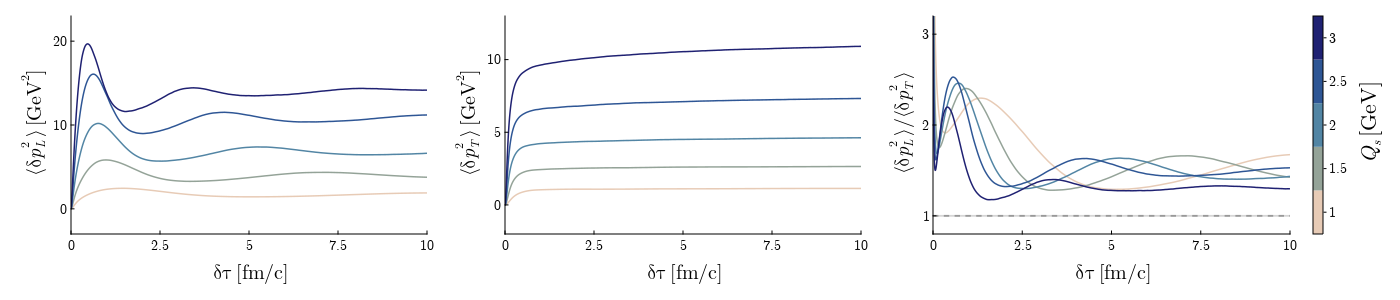

CairoScreen{Cairo.CairoSurfaceBase{UInt32}} with surface:
Cairo.CairoSurfaceBase{UInt32}(Ptr{Nothing} @0x000000000c91dfd0, 7000.0, 1500.0)


In [11]:
using CairoMakie
using ColorSchemes

segmented_cmap = cgrad(:lapaz, 16, categorical = true)
colors = [segmented_cmap[14], segmented_cmap[11], segmented_cmap[8], segmented_cmap[5], segmented_cmap[2]]
linestyles = [:dash, :dashdot, :dot]

fig = Figure(resolution = (1400, 300), font = "CMU Serif")
ylabels = [L"\langle\delta p_L^2\,\rangle\,\mathrm{[GeV^2]}", L"\langle\delta p_T^2\,\rangle\,\mathrm{[GeV^2]}", 
        L"\langle\delta p^2_L\,\rangle/\langle\delta p^2_T\,\rangle"]
axes = [Axis(fig[1, i], 
        xlabel=L"\delta\tau\,\mathrm{[fm/c]}", ylabel=ylabels[i],
        rightspinevisible = false, topspinevisible = false, xlabelsize = 20, ylabelsize= 20, xticklabelsize=14, yticklabelsize=14,
        xtickalign = 1, xticksize=4, ytickalign=1, yticksize=4, xgridvisible = false, ygridvisible = false) for i in 1:3]

i = 1
iq = 1
tag_low, tag_high = quarks[iq] * "_Qs_" * Qss[1], quarks[iq] * "_Qs_" * Qss[length(Qss)]
δτ_wong = Float64.(tau_wong[tag_low])
mom_broad_L_low, mom_broad_L_high = mom_broad_wong[tag_low][:, 3] , mom_broad_wong[tag_high][:, 3]
# band!(axes[1], δτ_wong, mom_broad_L_low, mom_broad_L_high; color = transpose(reverse(δτ_wong)), colormap = (:lapaz, 0.1))
mom_broad_T_low, mom_broad_T_high = mom_broad_wong[tag_low][:, 1] + mom_broad_wong[tag_low][:, 2], mom_broad_wong[tag_high][:, 1] + mom_broad_wong[tag_high][:, 2]
# band!(axes[2], δτ_wong, mom_broad_T_low, mom_broad_T_high; color = transpose(reverse(δτ_wong)), colormap = (:lapaz, 0.1))
ratio_low, ratio_high = mom_broad_L_low./mom_broad_T_low, mom_broad_L_high./mom_broad_T_high

for iQs in 1:length(Qss)
        tag_wong = quarks[iq] * "_Qs_" * Qss[iQs]
        δτ_wong = Float64.(tau_wong[tag_wong])

        mom_broad_L_wong = mom_broad_wong[tag_wong][:, 3]
        lines!(axes[1], δτ_wong, mom_broad_L_wong, linewidth = 1.5, color=colors[iQs])
        mom_broad_T_wong = mom_broad_wong[tag_wong][:, 1] + mom_broad_wong[tag_wong][:, 2]
        lines!(axes[2], δτ_wong, mom_broad_T_wong, linewidth = 1.5, color=colors[iQs])
        ratio = mom_broad_L_wong./mom_broad_T_wong
        string_as_varname("wong_Qs_"*string(iQs), lines!(axes[3], δτ_wong, ratio, linewidth = 1.5, color=colors[iQs]))
end

for i in 1:3
        xlims!(axes[i], 0, 10)
        axes[i].xticks = ([0, 2.5, 5, 7.5, 10], ["0", "2.5", "5", "7.5", "10"])
end
ylims!(axes[1], -3, 23)
ylims!(axes[2], -2, 13)
ylims!(axes[3], 0.8, 3.2)
axes[1].yticks = ([0, 10, 20], ["0", "10", "20"])
axes[3].yticks = ([1, 2, 3], ["1", "2", "3"])

lines!(axes[3], δτ_wong, ones(length(δτ_wong)), linewidth = 1.8, color=(:grey60, 0.4))
lines!(axes[3], δτ_wong, ones(length(δτ_wong)), linewidth = 1.8, color=:grey60, linestyle=:dash)

cbar = Colorbar(fig[1, 4], limits = (1, 6), colormap =  cgrad(colors, 5, categorical = true), size = 25, labelsize = 22, width = 10, flipaxis = true,
ticksize=3, tickalign = 0, ticklabelsize = 14, height = Relative(1), label=L"Q_s\,\mathrm{[GeV]}")
cbar.ticks = ([1.5, 2.5, 3.5, 4.5, 5.5],  Qss)

display(fig)
save("plots/mom_broad_Qs_beauty.png", fig, px_per_unit = 5.0) 

In [6]:
# [Gev * fm]
hbarc = 0.197326 

0.197326

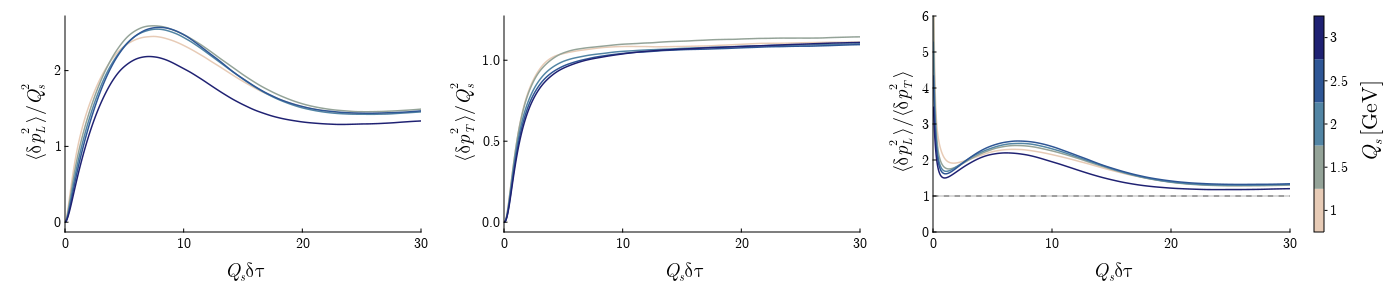

CairoScreen{Cairo.CairoSurfaceBase{UInt32}} with surface:
Cairo.CairoSurfaceBase{UInt32}(Ptr{Nothing} @0x000000000c229710, 7000.0, 1500.0)


In [10]:
using CairoMakie
using ColorSchemes

segmented_cmap = cgrad(:lapaz, 16, categorical = true)
colors = [segmented_cmap[14], segmented_cmap[11], segmented_cmap[8], segmented_cmap[5], segmented_cmap[2]]
linestyles = [:dash, :dashdot, :dot]

fig = Figure(resolution = (1400, 300), font = "CMU Serif")
ylabels = [L"\langle\delta p_L^2\,\rangle/Q_s^2", L"\langle\delta p_T^2\,\rangle/Q_s^2", 
        L"\langle\delta p^2_L\,\rangle/\langle\delta p^2_T\,\rangle"]
axes = [Axis(fig[1, i], 
        xlabel=L"Q_s\delta\tau", ylabel=ylabels[i],
        rightspinevisible = false, topspinevisible = false, xlabelsize = 20, ylabelsize= 20, xticklabelsize=14, yticklabelsize=14,
        xtickalign = 1, xticksize=4, ytickalign=1, yticksize=4, xgridvisible = false, ygridvisible = false) for i in 1:3]

i = 1
iq = 1
δτ_wong = Float64.(tau_wong[tag_low])

for iQs in 1:length(Qss)
        tag_wong = quarks[iq] * "_Qs_" * Qss[iQs]
        Qs_value = parse(Float64, Qss[iQs])
        δτ_wong = Float64.(tau_wong[tag_wong])*Qs_value/hbarc

        mom_broad_L_wong = mom_broad_wong[tag_wong][:, 3]/Qs_value^2
        lines!(axes[1], δτ_wong, mom_broad_L_wong, linewidth = 1.5, color=colors[iQs])
        mom_broad_T_wong = (mom_broad_wong[tag_wong][:, 1] + mom_broad_wong[tag_wong][:, 2])/Qs_value^2
        lines!(axes[2], δτ_wong, mom_broad_T_wong, linewidth = 1.5, color=colors[iQs])
        ratio = mom_broad_L_wong./mom_broad_T_wong
        string_as_varname("wong_Qs_"*string(iQs), lines!(axes[3], δτ_wong, ratio, linewidth = 1.5, color=colors[iQs]))
end

for i in 1:3
        xlims!(axes[i], 0, 30)
        axes[i].xticks = ([0, 10, 20, 30], ["0", "10", "20", "30"])
end
# ylims!(axes[1], 0, 1.6)
# ylims!(axes[2], 0, 0.8)
ylims!(axes[3], 0, 6)
# axes[1].yticks = ([0.5, 1, 1.5], ["0.5", "1", "1.5"])
# axes[2].yticks = ([0.2, 0.4, 0.6, 0.8], ["0.2", "0.4", "0.6", "0.8"])
# axes[3].yticks = ([1, 3, 5], ["1", "3", "5"])

lines!(axes[3], δτ_wong, ones(length(δτ_wong)), linewidth = 1.8, color=(:grey60, 0.4))
lines!(axes[3], δτ_wong, ones(length(δτ_wong)), linewidth = 1.8, color=:grey60, linestyle=:dash)

cbar = Colorbar(fig[1, 4], limits = (1, 6), colormap =  cgrad(colors, 5, categorical = true), size = 25, labelsize = 22, width = 10, flipaxis = true,
ticksize=3, tickalign = 0, ticklabelsize = 14, height = Relative(1), label=L"Q_s\,\mathrm{[GeV]}")
cbar.ticks = ([1.5, 2.5, 3.5, 4.5, 5.5],  Qss)

display(fig)
save("plots/mom_broad_tauQs_beauty.png", fig, px_per_unit = 5.0) 